<a href="https://colab.research.google.com/github/wing787/books-python-satellite-data-analysis-basic/blob/main/2_use_STAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab利用時には以下のコマンドを実行する（初回のみ）←実行済み
# !apt-get install -y libspatialindex-dev

In [2]:
# STACを利用するために、あらためてライブラリのインストールを行う。
# Colab利用時にはインストール後ランタイムを再起動する。（放置していて、ランタイム接続が切れていれば必ず再度実行）
# !pip install cartopy
# !pip install pygeos
# !pip install rtree
# !pip install sat-search
# !pip install python-dateutil==2.7.5
# !pip install intake-stac==0.3.0
# !pip install rasterio
# !pip install pystac-client

In [3]:
import os, json
from shapely.geometry import MultiPolygon, Polygon, box
from fiona.crs import from_epsg
from pystac_client import Client
import numpy as np
import intake
from satsearch import Search
from io import BytesIO
import urllib
from PIL import Image
from skimage import io
from IPython.display import display, Image
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from osgeo import gdal
import warnings
warnings.filterwarnings('ignore')

print('done')

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-3-45b91f06d73f>:13: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

done


In [4]:
AREA = [
    [
        139.708159,
        35.6593884
    ],
    [
        139.7067857,
        35.4817801
    ],
    [
        139.8619676,
        35.4817801
    ],
    [
        139.8578477,
        35.6493456
    ],
    [
        139.708159,
        35.6593884
    ]
]

# 左回りもしくは右回りに対応。
# 地図を左に大きく動かして場所を選択したり、右側に何周かして場所を選択したりすると、上記の経度が-180や、+180度を超えたりする。
# その際には、下のコードを実行する。
for i in range(len(AREA)):
    if AREA[i][0] >= 0:
        AREA[i][0] = AREA[i][0]%360
    else:
        AREA[i][0] = -(abs(AREA[i][0]%360) + 360)

In [5]:
# AREAから最小緯度・経度、最大緯度・経度を取得する。
areaLon = []
areaLat = []
# iterating each number in list
for coordinate in AREA:
    areaLon.append(coordinate[0])
    areaLat.append(coordinate[1])

minLon = np.min(areaLon)  # min longitude
maxLon = np.max(areaLon)  # max longitude
minLat = np.min(areaLat)  # min latitude
maxLat = np.max(areaLat)  # max latitude
print(f'minLon: {minLon}')
print(f'maxLon: {maxLon}')
print(f'minLat: {minLat}')
print(f'maxLat: {maxLat}')

minLon: 139.7067857
maxLon: 139.8619676
minLat: 35.4817801
maxLat: 35.6593884


In [6]:
bbox = [minLon, minLat, maxLon, maxLat]
dates = '2021-04-10/2021-06-10'  # '20210410', '20210610'
URL='https://earth-search.aws.element84.com/v0'

results = Search(url=URL,
                collections=['sentinel-s2-l2a-cogs'], # sentinel-s2-l1c, sentinel-s2-l2a-cogs, sentinel-s2-l2aが指定できます
                datetime=dates,
                bbox=bbox,
                sort=['<datetime'])

In [7]:
print('%s items' % results.found())  # 検索で取得したデータ数を表示
items = results.items()
items.save('sentinel-s2-l2a-cogs.json')

12 items


In [8]:
# 取得結果のカタログ化。画像のダウンロード用に用いる。
catalog = intake.open_stac_item_collection(items)
# list(catalog)
# 取得した結果について雲量を簡単に確認する場合
# print(items.summary(['date', 'id', 'eo:cloud_cover']))
gf = gpd.read_file('/content/sentinel-s2-l2a-cogs.json')
# display(gf)

In [9]:
# 雲量で並び替え
gfSroted = gf.sort_values('eo:cloud_cover').reset_index(drop=True)
gfSroted.head()

,id,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,geometry
0,S2A_54SUE_20210517_0_L2A,2021-05-17 01:37:22+00:00,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20210517T012701_N0300_R074_T54SUE_2...,100.00,0.00,False,2021-05-18 04:17:45.516000+00:00,2021-05-18 04:17:45.516000+00:00,"POLYGON ((138.80484 35.13501, 138.77761 36.124..."
1,S2A_54SUE_20210507_0_L2A,2021-05-07 01:37:21+00:00,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20210507T012651_N0300_R074_T54SUE_2...,99.58,0.00,False,2021-05-07 06:26:05.132000+00:00,2021-05-07 06:26:05.132000+00:00,"POLYGON ((138.80484 35.13501, 138.77761 36.124..."
2,S2A_54SUE_20210427_0_L2A,2021-04-27 01:37:19+00:00,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20210427T012651_N0300_R074_T54SUE_2...,100.00,8.43,True,2021-04-27 07:07:07.195000+00:00,2021-04-27 07:07:07.195000+00:00,"POLYGON ((138.80484 35.13501, 138.77761 36.124..."
3,S2B_54SUE_20210601_0_L2A,2021-06-01 01:37:23+00:00,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20210601T012659_N0300_R074_T54SUE_2...,100.00,11.46,True,2021-06-01 06:54:18.880000+00:00,2021-06-01 06:54:18.880000+00:00,"POLYGON ((138.80484 35.13501, 138.77761 36.124..."
4,S2B_54SUE_20210422_0_L2A,2021-04-22 01:37:16+00:00,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20210422T012649_N0300_R074_T54SUE_2...,100.00,21.50,True,2021-04-23 19:34:50.984000+00:00,2021-04-23 19:34:50.984000+00:00,"POLYGON ((138.80484 35.13501, 138.77761 36.124..."


['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL']


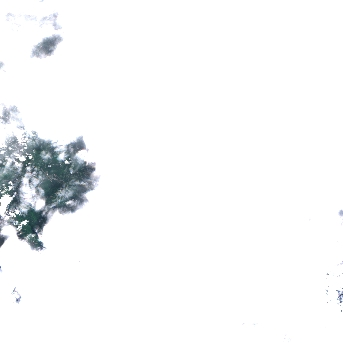

In [10]:
# 雲量が最も少ない画像を取得
item = catalog[gfSroted.id[0]]

# 画像に含まれるデータを確認
# 手動でダウンロードしたものと同じバンド情報が入っていることをわかる
print(list(item))

# サムネイル画像の表示（RGB画像）
Image(item['thumbnail'].urlpath)

In [11]:
def getPreview(thumbList, r_num, c_num, figsize_x=12, figsize_y=12):
  """
  サムネイル画像を指定した引数に応じて行列状に表示
  r_num: 行数
  c_num: 列数
  """
  thumbs = thumbList
  f, ax_list = plt.subplots(r_num, c_num, figsize=(figsize_x, figsize_y))
  for row_num, ax_row in enumerate(ax_list):
    for col_num, ax in enumerate(ax_row):
      if len(thumbs) < r_num * c_num:
        len_shortrage = r_num * c_num - len(thumbs)  # 行列の不足分を算出
        count = row_num * c_num + col_num
        if count < len(thumbs):
          ax.label_outer()  # サブプロットのタイトルと、軸のタイトルが重複しないようにする
          ax.imshow(io.imread(thumbs[row_num * c_num + col_num]))
          ax.set_title(thumbs[row_num * c_num + col_num][60:79])
        else:
          for i in range(len_shortrage):
            blank = np.zeros([100, 100, 3], dtype=np.unit8)
            blank.fill(255)
            ax.label_outer()
            ax.imshow(blank)
      else:
        ax.label_outer()
        ax.imshow(io.imread(thumbs[row_num * c_num + col_num]))
        ax.set_title(thumbs[row_num * c_num + col_num][60:79])

  return plt.show()

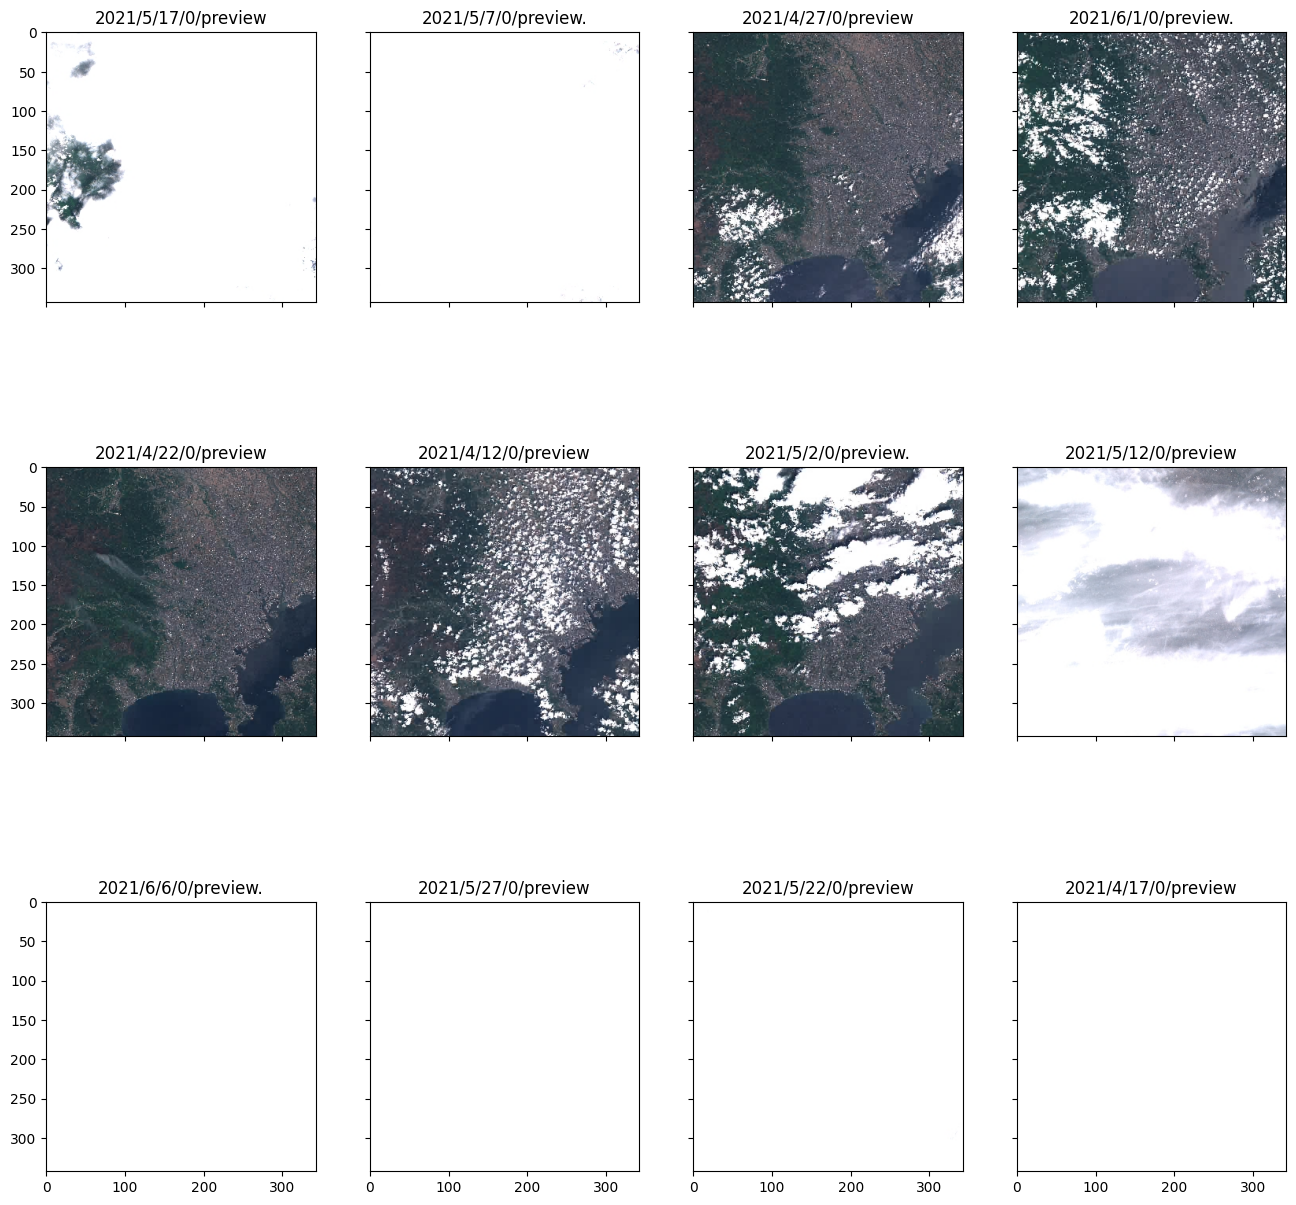

In [12]:
allthumburl = [catalog[gfSroted.id[i]]['thumbnail'].urlpath for i in range(12)]
getPreview(allthumburl[0:13], 3, 4, 16, 16)

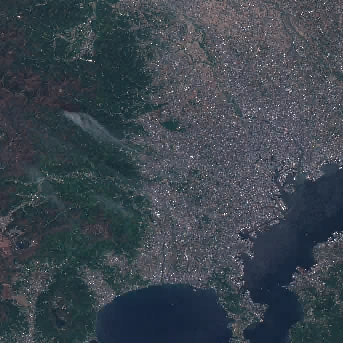

In [13]:
# 雲量が最も少ない画像を取得
item = catalog[gfSroted.id[4]]

# サムネイル画像の表示（RGB画像）
Image(item['thumbnail'].urlpath)

In [14]:
bandLists = ['B04', 'B03', 'B02']
file_url = [item[band].metadata['href'] for band in bandLists]
print(file_url)

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2B_54SUE_20210422_0_L2A/B04.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2B_54SUE_20210422_0_L2A/B03.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2B_54SUE_20210422_0_L2A/B02.tif']


In [15]:
# 画像の作成フォルダ作成
folder_name = 'sentinel2COG'
os.makedirs(folder_name, exist_ok=True)
RGB_dir = 'content/' + folder_name

In [16]:
# 参照：https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

bbox = box(minLon, minLat, maxLon, maxLat)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs='epsg:32654')  # Sentinel-2の画像に合わせる

def getFeatures(gdf):
  """rasterioで読み取れる形のデータへ変換するための関数"""
  return [json.loads(gdf.to_json())['features'][0]['geometry']]


coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[396762.7785510754, 3927067.932522922], [396990.4148314546, 3946767.1466804133], [382943.32116527937, 3946940.915480255], [382684.6295948352, 3927241.3322548624], [396762.7785510754, 3927067.932522922]]]}]


In [19]:
# read image
b2 = rio.open(file_url[2])
b3 = rio.open(file_url[1])
b4 = rio.open(file_url[0])

# 出力ファイル名
RGB_path = os.path.join(RGB_dir, 'sentinel-2_l2a-cogs' + '.tif')

# 念の為
if not os.path.exists(RGB_dir):
    os.makedirs(RGB_dir)

# GeoTIFFの作成
RGB_color = rio.open(RGB_path,'w',driver='Gtiff', # driverにGtiff(GeoTIFF)
                    width=b4.width, height=b4.height, # 画像の高さや幅を指定。B04のバンドと同じ大きさにしています
                    count=3, # 3つのバンドを利用 (B02, B03, B04)
                    crs=b4.crs, # crsもB04と同様。epsg:32654
                    transform=b4.transform, # データに対する変換も同様のもの
                    dtype=rio.uint16 # データ型を指定
                    )
# 各々のバンド情報をRGB_colorに書き込み
RGB_color.write(b2.read(1), 3)  # 青
RGB_color.write(b3.read(1), 2)  # 緑
RGB_color.write(b4.read(1), 1)  # 赤
RGB_color.close()

with rio.open(RGB_path) as src:
  out_image, out_transform = rio.mask.mask(src, coords, crop=True)  # mask処理の実行
  out_meta = src.meta  # 作成する画像の情報はもともとの画像と同様のものにする

# メタ情報の更新
out_meta.update({'driver': 'GTiff',
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform})


# 画像の書き出し
with rio.open(RGB_path, 'w', **out_meta) as dest:
  dest.write(out_image)

# 画像表示のため8bit形式で書き出し、画像の色味も調整する
scale = '-scale 0 255 0 25'
options_list = ['-ot Byte', '-of Gtiff', scale]
options_string = ' '.join(options_list)

gdal.Translate(os.path.join(RGB_dir, 'sentinel-2_l2a-cogs_Masked' + '.tif'), os.path.join(RGB_dir, 'sentinel-2_l2a-cogs' + '.tif'), options = options_string)

print('done')

done


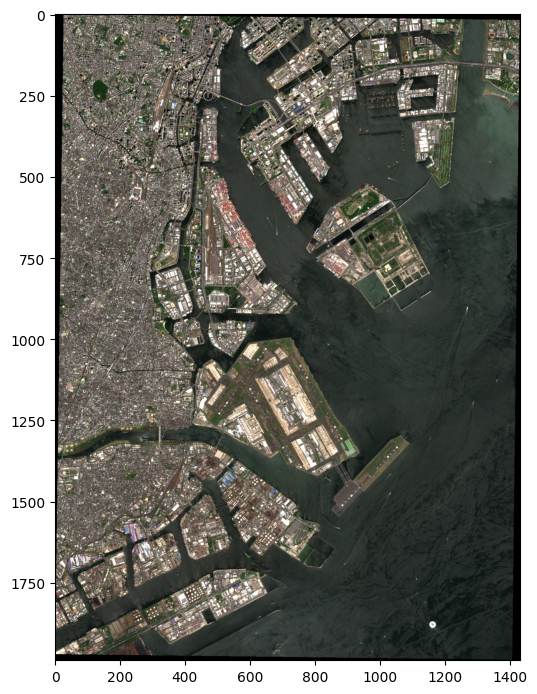

<Axes: >

In [21]:
plt.figure(figsize=(6, 10))
RGB_2017octCOG = rio.open('./content/sentinel2COG/sentinel-2_l2a-cogs_Masked.tif')
show(RGB_2017octCOG.read([1,2,3]))